# One-Dimensional Climate Models: Brown Dwarfs w/ Disequilibrium Chemistry with Self-Consistent Kzz

In this tutorial you will learn how to run 1d climate models with the effects of disequilibrium chemistry as was done for the Elf-OWL Grid [Mukherjee et al. 2024](https://ui.adsabs.harvard.edu/abs/2024arXiv240200756M/abstract) (note this should also be cited if using this code/tutorial). 

What you should already be familiar with: 

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to run a basic 1d brown dwarf tutorial](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)


What should have already downloaded: 

1. [Download](https://zenodo.org/record/5590989#.Yzy2YOzMI8a) 1460 PT, 196 wno Correlated-K Tables from Roxana Lupu to be used by the climate code for opacity 
2. [Download](https://zenodo.org/record/5063476/files/structures_m%2B0.0.tar.gz?download=1) the sonora bobcat cloud free `structures_` file so that you can have a simple starting guess 

**NEW:**

3. [Download the .npy](https://doi.org/10.5281/zenodo.10895826) and place them in picaso_refdata folder/climate_INPUTS/ktable_by_molecule/

> **_NOTE:_**  Tip for getting data from zenodo: pip install zenodo_get then it you can simply retrieve a zenodo posting via the command zenodo_get 10.5281/zenodo.10895826 


### First, check that you have downloaded and placed the correlated-k files in the correct folder

In [ ]:
import os;import glob#
[i.split('/')[-1].split("_")[0] for i in glob.glob(
    os.path.join(os.environ['picaso_refdata'],'climate_INPUTS','ktable_by_molecule','*npy')
)]
#should see a list of molecules (ie. ['H3+', 'FeH', 'C2H2'....])

['H3+',
 'FeH',
 'C2H2',
 'LiH',
 'H2S',
 'C2H4',
 'VO',
 'CO',
 'OCS',
 'MgH',
 'SO2',
 'LiCl',
 'CaH',
 'CO2',
 'Rb',
 'Na',
 'CH4',
 'TiO',
 'CrH',
 'HCN',
 'Li',
 'O2',
 'O3',
 'H2O',
 'Fe',
 'Cs',
 'H2',
 'SiO',
 'PH3',
 'NH3',
 'LiF',
 'K',
 'C2H6',
 'N2',
 'TiH']

In [2]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
from astropy import constants as const
from astropy import units as u
import sys
import pandas as pd

## Setting up Initial Run (highlighting main differences for disequilibrium)

In [ ]:
sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_bobcat/structures_m+0.0' #recommended download #2 above

gases_fly = ['CO','CH4','H2O','NH3','CO2','N2','HCN','H2','He','PH3','C2H2','Na','K','TiO','VO','FeH']

opacity_ck = jdi.opannection(method='resortrebin',preload_gases=gases_fly) # grab your opacities


In [4]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation


tint= 700 
grav = 316 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

nlevel = 91 


We recommend starting with Sonora-Bobcat models as an initial guess. 

In [ ]:
pressure,temp_guess = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{tint}g{grav}nc_m0.0.dat"),
                            usecols=[1,2],unpack=True, skiprows = 1)


nofczns = 1 # number of convective zones initially. Let's not play with this for now.

nstr_upper = 79 # top most level of guessed convective zone
nstr_deep = nlevel -2 # this is always the case. Dont change this
nstr = np.array([0,nstr_upper,89,0,0,0]) # initial guess of convective zones

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is


### Setting K$_{zz}$

We will add one more concept which is the addition of  K$_{zz}$ [cm$^2$/s]. K$_{zz}$ is the eddy diffusion constant, which sets the strength of vertical mixing. In `PICASO` we have two options for  K$_{zz}$: 
 
 1. Constant value: sets a constant at every atmospheric layer
 2. Self consistent (see Eqn. 27 and 28 in [Mukherjee et al 2022](https://arxiv.org/pdf/2208.07836.pdf))


**New code parameters**: 

1. `diseq_chem=True` : Turns on disequilibrium chemistry
2. `self_consistent_kzz` : (True/False) This solves self consistently for 
3. `save_all_kzz` : (True/False) Similar to `save_all_profiles` this saves your intermediate k_zz values if you are trying to solve for a `self_consistent_kzz=True`.
4. `kz` : constant value if `self_consistent_kzz=False`

**Which of those 6 do I need change change**

Likely you will only be changing `kz` and/or, for example, playing around with a `self_consistent_kzz` vs a `constant profile`. Unless you are certain, we recommend the following set of `gases_fly` to remain unchanged. 

In this case, we are going to use a self-consistent kzz. Because of this we don't need to define `kz`, we just need to make sure that `self_consistent_kzz = True`.


In [ ]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                        nstr = nstr, nofczns = nofczns , rfacv = rfacv)
mh=1#NOT LOG
cto_relative = 1 #relative to solar

#now that we are not using preweighted ck tables we need to tell picaso how to compute chemistry on the fly 
cl_run.atmosphere(mh=mh, cto_relative=cto_relative, chem_method='visscher', quench=True)

out = cl_run.climate(opacity_ck, save_all_profiles = True, with_spec=True,
        save_all_kzz = False, self_consistent_kzz=True,diseq_chem = True)


SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
I am updating kzz
I dont have fluxes, let me compute them
Computed quenched levels at {'CO-CH4-H2O': 77, 'CO2': 67, 'NH3-N2': 80, 'HCN': 77, 'PH3': 74}
Iteration number  0 , min , max temp  234.89099914770745 2710.2202248496865 , flux balance  -0.128332994941577
Iteration number  1 , min , max temp  238.53381977274134 2715.702993986178 , flux balance  -0.10231940933762002
Iteration number  2 , min , max temp  242.07362702278343 2721.3165643510742 , flux balance  -0.07539865238579284
Iteration number  3 , min , max temp  245.52369108584193 2727.06801870182 , flux balance  -0.04754701660643165
Iteration number  4 , min , max temp  248.89648486450838 2732.9639774309085 , flux balance  -0.01874184595364149
Iteration number  5 , min , max temp  250.99605542742543 2736.8095293600823 , flux balance  3.171952597177193e-05
Iteration number  6 , min , max temp  251.00856079143088 2736.8

## Compare Diseq and Chemeq Climate Profile 

For the case we chose to do a self-consistent kzz instead of a low, constantt kzz. We also use the resort-rebin chemistry method compared to the pre-weighted CK tables. For more information about the difference between these, you can look at the [Fun with Chem notebook]()

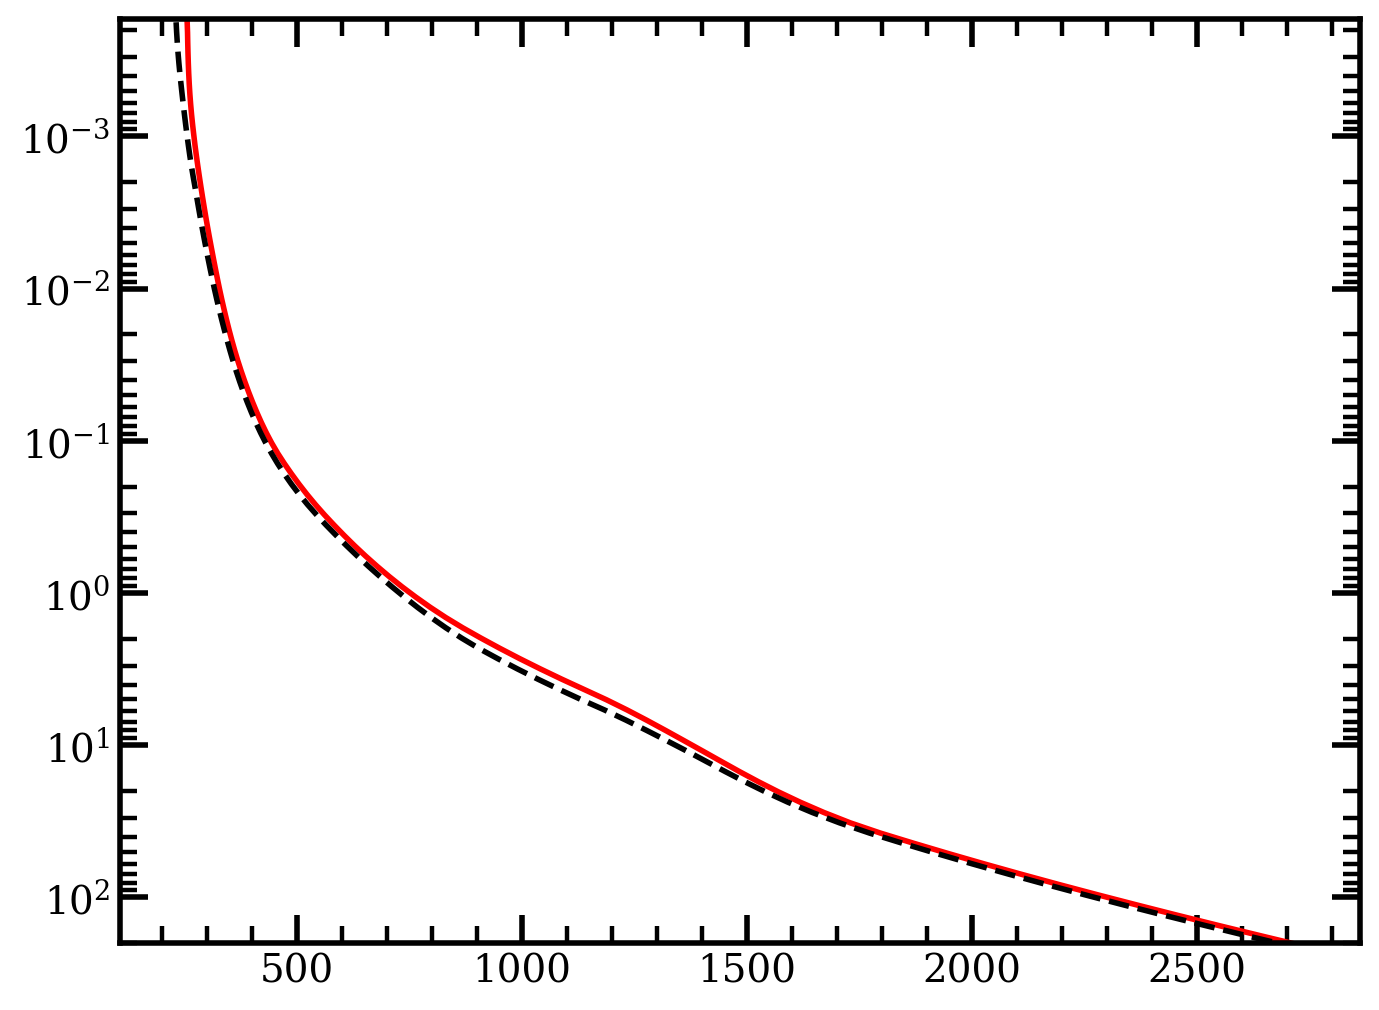

In [7]:
plt.ylim(200,1.7e-4)
plt.semilogy(out['temperature'],out['pressure'],"r", label='Resort-Rebin, Chemical Disequilibrium, Self Consistent Kzz')
plt.semilogy(temp_guess,pressure,color="k",linestyle="--", label='Pre-weighted CK, Chemical Equilibrium')